## Hypothesis testing

Выполнила: Галиуллина Алина
<br>
Тема работы: проверка статистических гипотез
<br>
Основные комментарии по существу задачи будут в ячейках "Markdown". Примечания по коду будут закомментированы в ячейках самого кода

<b>Задача 1. Nursing Home Data</b>

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm

from scipy import stats


In [2]:
# Указываем рабочую папку
os.chdir(r"C:\Users\qwerty\Desktop\ИТМО\АД на python\Задачи для лабораторной 4\Nursing Home Data")

In [3]:
# Между данными в различных столбцах различное количество пробелов, поэтому используем регулярное выражение в sep.
data = pd.read_csv('Nursing Home Data_data.txt', sep =r"\s+")

# Выведем датафрейм
data.head()

,BED,MCDAYS,TDAYS,PCREV,NSAL,FEXP,RURAL
0,244,128,385,23521,5230,5334,0
1,59,155,203,9160,2459,493,1
2,120,281,392,21900,6304,6115,0
3,120,291,419,22354,6590,6346,0
4,120,238,363,17421,5362,6225,0


### ШАГ 0. Знакомство с данными и их осмысление. Постановка задачи.
<br>
В данных нет пропусков, что упрощает нам работу.

Имеем данные о 52-х больницах в штате Нью-Мексико (1988 год) с информацией о количестве коек, количестве пациентов в год, годовом окладе медсестры и других сведениях по каждой из больниц.
Полный перечень атрибутов будет приведен ниже.
<br>

<b>Задача </b>: сравнить годовые оклады медсестер, работающих за городом и в городе.

<b>Описание переменных</b>

BED = число коек в больнице

MCDAYS = количество дней пребывания пациентов в стационаре за год (в сотнях)

TDAYS = общее количество дней пребывания пациентов за год (в сотнях)

PCREV = годовой доход от ухода за пациентами (в сотнях долларов)

NSAL = годовой оклад медсестры (в сотнях долларов)

FEXP = расходы больницы за год (в сотнях долларов)

RURAL = код типа больницы: загородная (код 1) или городская (код 0)

In [4]:
# В данных нет пропусков 
data[data.isnull()].count()

BED       0
MCDAYS    0
TDAYS     0
PCREV     0
NSAL      0
FEXP      0
RURAL     0
dtype: int64

In [5]:
# Выведем статистику по зарплатам для каждой из 2-х исследуемых групп.
grouped = data.groupby(['RURAL'])['NSAL']
grouped.describe()

,count,mean,std,min,25%,50%,75%,max
RURAL,,,,,,,,
0,18.0,4859.500000,1820.990301,1955.0,3129.5,4940.5,6287.00,7489.0
1,34.0,3258.705882,1278.214985,1288.0,2071.5,3124.5,4124.25,6059.0


Имеем 18 городских и 34 загородных (сельских) больниц. Интересоваться будем годовыми окладами медсестер (т.е. значениями переменной NSAL) в рамках поставленной задачи.

Сначала про оклады медсестер в каждом типе больницы.

Городские: среднее значение и медиана довольно близки (около 4900 сотен долларов). Межквартильный размах 3157.5 (сотен долларов), стандартное отклонение 1820.99

Сельские: среднее значение и медиана уже не так близки, но все равно сопоставимы (3258.71 и 3124.5 сотен долларов соответственно). Межквартильный размах 2052.75, стандартное отклонение 1278.22. Везде далее будем иметь в виду единицы измерения сотни долларов, чтобы каждый раз не уточнять это.

Теперь сравнение. У медсестер сельских больниц меньше: минимальная зарплата, максимальная зарплата, среднее значение з/п и медианное значение. 
<br>

### ШАГ 1. Отбор переменных
<br>
В данной задаче интересуемся значениями зарплат медсестер (NSAL) в зависимости от места работы (т.е. значения атрибута RURAL)

In [6]:
# Выделим из исходного датафрейма интересующие нас столбцы
sal_town = data[data['RURAL'] == 0]['NSAL']
sal_rural = data[data['RURAL'] == 1]['NSAL']
# Зададим названия
sal_town.name = 'salary_town'
sal_rural.name = 'salary_rural'

### ШАГ 2. Стандартизация
<br>
Стандартизация в данном случае не обязательна, все данные по зарплатам представлены в одной и той же шкале (сотни долларов). При сравнении гистограмм распределений мы приведем частоты в нормированной шкале, в остальном будем пользоваться исходными данными.

### ШАГ 3. Проверка гипотезы о нормальности распределений.
<br>
Перед тем, как непосредственно отвечать на вопрос задачи, построим гистограммы распределения зарплат и постараемся понять, с какими распределениями мы имеем дело.
<br>

In [7]:
"""
    Функция histogram для построения гистограммы и функции плотности нормального распределения.
    Выполним нормировку (задав density = 1)
    x: вектор pd.Series
"""
def histogram(x, n_bins):
    #  Параметры распределения: 
    #  математическое ожидание и стандартное отклонение
    mu = np.mean(x)
    sigma = np.std(x)
    #  Решетка точек для построения графика функции
    x_1 = np.linspace(np.min(x)/10, 1.5*np.max(x), 300)
    plt.figure(figsize=(10,8))
    pd.Series(x).hist(bins=n_bins, density=1)
    plt.plot(x_1, stats.norm.pdf(x_1, mu, sigma))
    x_pos = np.mean(x)
#     plt.text(x_pos, 0.0002, r'$f(x) = \frac{\exp(-(x-\mu)^2/2*\sigma^2)}{\sigma*\sqrt{2*\pi}}$',fontsize=12)
    plt.legend(labels  = ['theoretical', x.name])

Видим, что гистограмма для городских больниц ниже не особо напоминает нормальное распределение (точнее: гистограмма не особо соответствует теоретической функции плотности нормального распределения). Можем отметить, что есть и отклонения от симметричности, и от колоколообразной формы.

При изменении количества интервалов для построения гистограммы ситуация лучше не становится. Несмотря на то, что объем выборки мал (и мы более снисходительны к указанным выше отклонениям), я бы предположила, что распределение зарплат медсестер городских больниц не является нормальным.

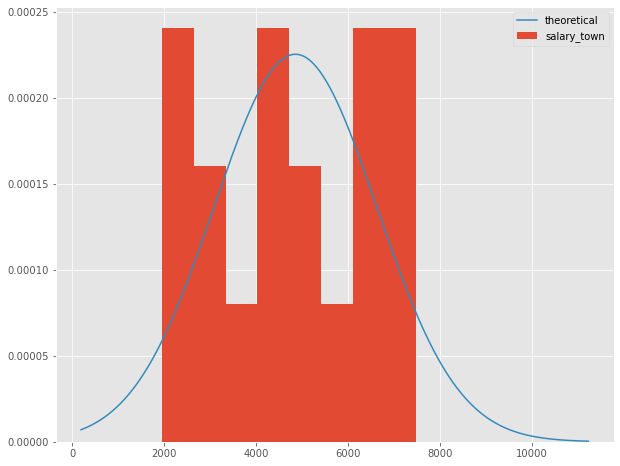

In [8]:
histogram(sal_town,8)

Построим аналогичное сравнение для сельских больниц. Видим отклонения от нормальности: нарушение симметрии (с обеих сторон, причем слева особенно), отклонения от колоколообразной формы.

Здесь распределение уже больше походит на нормальное с учетом нашей снисходительности из-за малого объема выборки.

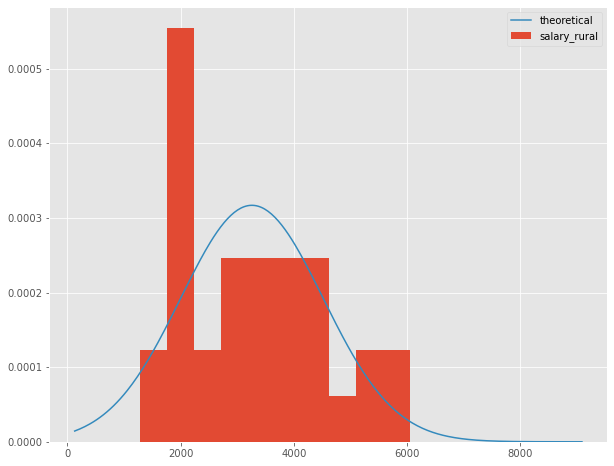

In [9]:
histogram(sal_rural, 10)

По гистограммам довольно затруднительно сделать однозначные выводы о нормальности распределений. Ситуация меняется в зависимости от количества отрезков разбиения. Также не стоит забывать об объемах наших выборок: 18 и 34 значения! В таких небольших выборках все "изъяны" распределения как будто усиливаются.

Попробуем, наконец, использовать критерий для проверки гипотезы о нормальности каждого из двух распределений. В обоих случаях имеем основную и альтернативную гипотезы:

<b>Гипотеза H0 </b>: распределение случайной величины "зарплата медсестры" в городе/за городом является нормальным

<b>Гипотеза H1 </b>: распределение случайной величины "зарплата медсестры" в городе/за городом не является нормальным

Для проверки гипотез воспользуемся критерием Шапиро - Уилка. Уровень значимости = 0.05. Если полученное p-value больше уровня значимости, то нет оснований отвергать нулевую гипотезу. Иначе - будем отвергать нулевую гипотезу.

In [10]:
"""
    Функция shapiro_test для проверки гипотезы о нормальности распределения выборки
    x: вектор pd.Series
    alpha: число float
"""
def shapiro_test(x,alpha):
    if stats.shapiro(x)[1] > alpha:
        print('Не отвергаем H0 о нормальности распределения, p-value =', stats.shapiro(x)[1])
    elif stats.shapiro(x)[1] < alpha:
        print('Отвергаем H0 о нормальности распределения, p-value =', stats.shapiro(x)[1])
    else:
        print('Требуется более подробное рассмотрение')

alpha = 0.05
print('Для городских з/п:')
shapiro_test(sal_town, alpha)

print('Для сельских з/п:')
shapiro_test(sal_rural, alpha)

Для городских з/п:
Не отвергаем H0 о нормальности распределения, p-value = 0.26659053564071655
Для сельских з/п:
Не отвергаем H0 о нормальности распределения, p-value = 0.0717819407582283


Видим, что гипотеза о нормальности распределения не отвергается (для з/п городских и сельских медсестер). Иными словами - распределения зарплат нормальны.

Кому же верить: критерию или собственным глазам? Попробуем еще один метод проверки распределения на нормальность - график QQ-plot. Если кратко: на этом графике отображено теоретическое распределение частот (в случае нормального распределения) и распределение частот на нашей выборке.

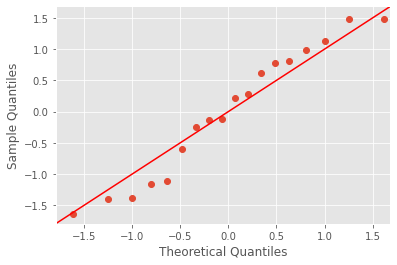

In [11]:
# Для з/п городских медсестер
fig = sm.qqplot(sal_town, fit = True ,line='45')
plt.show()

Если честно, легче не стало. Точки рассматриваемой выборки лежат не строго на прямой, порой достаточно сильно отклоняются. Но как измерить это "сильно"?

Пожалуй, это одна из самых сложных частей исследования: имея "противоречивые" результаты, прийти к собственному заключению. На данный момент мне затруднительно дать однозначный ответ о том, являются ли распределения нормальными, поэтому в Шаге 4 пойдем двумя путями. Получим результаты в предположении о нормальности, а также в предположении о не нормальности распределений, а затем сравним.

### ШАГ 4. Проверка гипотезы о равенстве зарплат.

#### 4.1. Проверка в предположении о нормальном распределении

В данном случае мы считаем распределения зарплат нормальными. Интересуют нас центры двух распределений, которые мы и будем сравнивать. В качестве типичных значений рассмотрим средние значения. 

Будем проверять гипотезу о равенстве средних (т.е. типичных) значений двух распределений. Для проверки применим критерий Стьюдента, предварительно проверив равенство дисперсий.

Итак, по порядку. Построим на одном графике гистограммы распределений.

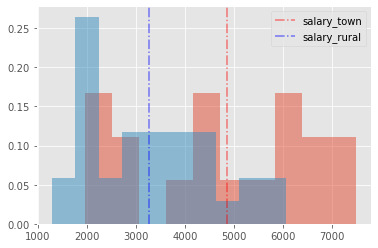

In [12]:
"""
    Функция two_hist для построения двух гистограмм и средних значений каждой из выборок.
    Для сравнения перейдем от абсолютных частот к относительным (задав weights)
    x: вектор pd.Series
    y: вектор pd.Series
"""
def two_hist(x, y):
    x.hist(alpha = 0.5, weights=[1./len(x)]*len(x), bins = 10)
    y.hist(alpha = 0.5, weights=[1./len(y)]*len(y), bins = 10)
    plt.axvline(x.mean(), alpha = 0.5, color = 'red', linestyle = '-.')
    plt.axvline(y.mean(), alpha = 0.5, color = 'blue', linestyle = '-.')
    plt.legend(labels  = [x.name, y.name])
two_hist(sal_town, sal_rural)

Критерием Флигнера-Килина проверим, равны ли дисперсии.

<b>Гипотеза H0 </b>: дисперсия случайной величины "зарплата медсестры" в городе и за городом одинакова

<b>Гипотеза H1 </b>: дисперсия случайной величины "зарплата медсестры" в городе и за городом различна

In [13]:
"""
    Функция fligner_test для проверки равенства дисперсий двух выборок.
    x: вектор pd.Series
    y: вектор pd.Series
    alpha: число float
"""
def fligner_test(x,y, alpha):
    if stats.fligner(x,y)[1] > alpha:
        print('Не отвергаем H0 о равенстве дисперсий, p-value =', stats.fligner(x,y)[1])
    elif stats.fligner(x,y)[1] < alpha:
        print('Отвергаем H0 о равенстве дисперсий, p-value =', stats.fligner(x,y)[1])
    else:
        print('Требуется более подробное рассмотрение')

alpha = 0.05
fligner_test(sal_town, sal_rural, alpha)

Не отвергаем H0 о равенстве дисперсий, p-value = 0.05254860862708049


Значение p-value больше уровня значимости 0.05, поэтому гипотезу о равенстве дисперсий не отвергаем.

Поэтому гипотезу о равенстве средних значений будем проверять с помощью (```ttest```) с опцией равенства дисперсий.

<b>Гипотеза H0 </b>: средние значения случайной величины "зарплата медсестры" в городе и за городом равны

<b>Гипотеза H1 </b>: средние значения случайной величины "зарплата медсестры" в городе и за городом различны

In [14]:
"""
    Функция t_test_equal для проверки равенства средних значений двух выборок при условии равенства дисперсий.
    x: вектор pd.Series
    y: вектор pd.Series
    alpha: число float
"""
def t_test_equal(x,y, alpha):
    if stats.ttest_ind(x,y, equal_var=True)[1] > alpha:
        print('Не отвергаем H0 о равенстве средних в предположении рав-ва дисперсий, p-value =', stats.ttest_ind(x,y,equal_var=True)[1])
    elif stats.ttest_ind(x,y,equal_var=True)[1] < alpha:
        print('Отвергаем H0 о равенстве средних в предположении рав-ва дисперсий, p-value =', stats.ttest_ind(x,y,equal_var=True)[1])
    else:
        print('Требуется более подробное рассмотрение')

alpha = 0.05
t_test_equal(sal_town, sal_rural, alpha)

Отвергаем H0 о равенстве средних в предположении рав-ва дисперсий, p-value = 0.0005409523097389856


Запомним данный результат. Теперь все же попробуем проверить гипотезу в случае, когда дисперсии не равны. Мотивацией к такой проверке служит тот факт, что p-value при использовании критерия Флигнера-Килина близко к 0.05.

In [15]:
"""
    Функция t_test_nonequal для проверки равенства средних значений двух выборок при условии неравенства дисперсий.
    x: вектор pd.Series
    y: вектор pd.Series
    alpha: число float
"""
def t_test_nonequal(x,y, alpha):
    if stats.ttest_ind(x,y)[1] > alpha:
        print('Не отвергаем H0 о равенстве средних в предположении различных дисперсий, p-value =', stats.ttest_ind(x,y,equal_var=False)[1])
    elif stats.ttest_ind(x,y)[1] < alpha:
        print('Отвергаем H0 о равенстве средних в предположении различных дисперсий, p-value =', stats.ttest_ind(x,y,equal_var = False)[1])
    else:
        print('Требуется более подробное рассмотрение')

alpha = 0.05
t_test_nonequal(sal_town, sal_rural, alpha)

Отвергаем H0 о равенстве средних в предположении различных дисперсий, p-value = 0.0026517310185132596


Таким образом, гипотеза о равенстве средних значений двух выборок отвергается. <b>Зарплаты медсестер в городских и сельских больницах различаются (статистически значимое различие с уровнем значимости 0.05) </b>

#### 4.2. Проверка в предположении о не нормальном распределении

В данном случае мы считаем распределения зарплат отличными от нормальных. Интересуют нас центры двух распределений, которые мы и будем сравнивать. В качестве типичных значений рассмотрим медианные значения. 

Будем проверять гипотезу о равенстве медиан (т.е. типичных значений) двух распределений. Для проверки применим критерий Манна-Уитни (т.к. выборки несвязные).

<b>Гипотеза H0 </b>: медианы случайной величины "зарплата медсестры" в городе/за городом равны

<b>Гипотеза H1 </b>: медианы случайной величины "зарплата медсестры" в городе/за городом различны

In [16]:
"""
    Функция mannwhitneyu_test для проверки равенства медиан двух выборок.
    x: вектор pd.Series
    y: вектор pd.Series
    alpha: число float
"""
def mannwhitneyu_test(x,y, alpha):
    if stats.mannwhitneyu(x,y)[1] > alpha:
        print('Не отвергаем H0 о равенстве медианных значений, p-value =', stats.mannwhitneyu(x,y)[1])
    elif stats.mannwhitneyu(x,y)[1] < alpha:
        print('Отвергаем H0 о равенстве медианных значений, p-value =', stats.mannwhitneyu(x,y)[1])
    else:
        print('Требуется более подробное рассмотрение')

alpha = 0.05
mannwhitneyu_test(sal_town, sal_rural, alpha)

Отвергаем H0 о равенстве медианных значений, p-value = 0.0017745599734812778


Таким образом, гипотеза о равенстве медианных значений двух выборок отвергается. <b>Зарплаты медсестер в городских и сельских больницах различаются (статистически значимое различие с уровнем значимости 0.05) </b>

### ШАГ 5. Построение ящиковой диаграммы, выводы

Построим ящиковую диаграмму. Медианная зарплата медсестер городских больниц больше, чем сельских. Тот факт, что медиана одного класса не попадает в межквартильный размах другого класса, подтверждает гипотезу о том, что такое различие в зарплатах не случайно (т.е. не обусловлено колебаниями в данных). Да, есть городские больницы, где медсестры получают примерно столько же, сколько и в среднем в сельских больницах, но при этом это не "типичные" случаи.  

Например, медианное значение з/п сельской медсестры = 3124.5 < 3129.5 = квартиль 25% городской медсестры.

Также можно видеть, что межквартильный размах для "городских" зарплат больше. 

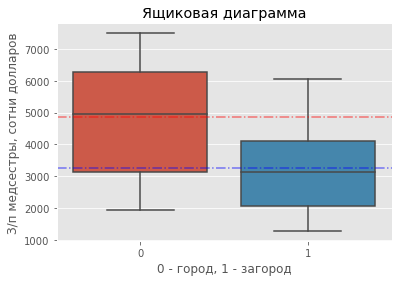

In [17]:
sns.boxplot(data=data, x='RURAL', y='NSAL')
plt.axhline(sal_town.mean(), alpha = 0.5, color = 'red', linestyle = '-.')
plt.axhline(sal_rural.mean(), alpha = 0.5, color = 'blue', linestyle = '-.')
plt.title('Ящиковая диаграмма')
plt.ylabel('З/п медсестры, сотни долларов')
plt.xlabel('0 - город, 1 - загород')
plt.show()

### Вывод по задаче №1:

В данной задаче сравнивались годовые зарплаты медсестер, а точнее: проверялась гипотеза о равенстве зарплат медсестер городских и сельских больниц. 

Зарплаты медсестер, работающих в городе и за городом, различны. Для обоснования данного вывода были построены гистограмммы распределений (с проверкой гипотезы об их нормальности), проверены гипотезы о: равенстве дисперсий, о равенстве медиан распределений и средних значений. Гипотеза о равенстве средних значений была отвергнута. Уровень значимости при проверке гипотез равнялся 0.05.

### P.S.
Хотелось бы добавить, что я так и не пришла к выводу о том, являются ли распределения з/п для обеих групп нормальными. Причиной сомнений стали не только гистограммы, но и одно из p-значений при проверке гипотезы о нормальности критерием Шапиро-Уилка: оно довольно близко к 0.05. 

К тому же, критерий Колмогорова-Смирнова отвергал гипотезу о нормальности распределений, что не облегчило задачу. Решено было воспользоваться критерием Шапиро-Уилка как наиболее "мощным" и подходящим для небольших выборок.

Обоснования к использованию именно такого значения для alpha я не привела, потому что вариантов то особо и не было:) Задаваться значением в 0.01 было бы странно для такой небольшой выборки, поэтому использовалось стандартное значение в 0.05.

<b>Задача 2. Unions and State Labor Law</b>

In [18]:
os.chdir(r"C:\Users\qwerty\Desktop\ИТМО\АД на python\Задачи для лабораторной 4\Unions and State Labor Law")

In [19]:
# Считаем данные
data = pd.read_csv('Unions and State Labor Law_data.txt', sep = '\t')

# Выведем датафрейм
data.head()

,STATE,DENS,COMP,RTW,PVT
0,NY,56.9,1,0,31.2
1,MI,49.6,1,0,30.2
2,WA,32.4,1,0,33.1
3,HI,54.6,1,0,24.7
4,AK,30.7,1,0,30.1


### ШАГ 0. Знакомство с даннымии их осмысление. Постановка задачи.
<br>
В данных нет пропусков, что упрощает нам работу.

Имеем данные о 50-х штатах США с информацией о проценте государственных работников профсоюзов, принятом или не принятом законе штата о праве на труд и т.д.
Полный перечень атрибутов будет приведен ниже.
<br>

<b>Задача</b>: Требуется сравнить процент муниципальных служащих, состоящих в профсоюзах в 1982 в разных штатах США в зависимости от того, распространяется ли в штате закон о ведении переговоров на муниципальных служащих.

<b>Описание переменных</b>

DENS = Процент работников государственного сектора в профсоюзах, 1982

COMP = Законы штата о ведении переговоров распространяются на государственных служащих (1) или нет (0)

RTW = Закон штата о праве на труд (1) или нет (0)

PVT = Процент работников частного сектора в профсоюзах, 1982

In [20]:
# В данных нет пропусков 
data[data.isnull()].count()

  STATE    0
DENS       0
COMP       0
RTW        0
PVT        0
dtype: int64

In [21]:
# Выведем статистику по проценту муниципальных служащих в профсоюзах. Сгруппируем по тому, принят закон о праве на труд или нет
grouped = data.groupby(['COMP'])['DENS']
grouped.describe()

,count,mean,std,min,25%,50%,75%,max
COMP,,,,,,,,
0,23.0,27.660870,6.701407,13.4,23.25,28.6,32.25,42.3
1,27.0,38.140741,12.611572,13.7,29.85,37.3,48.65,61.1


Имеем 23 штата, где закон о ведении переговоров не распространяется на муниципальных работников, и 27 штатов, где распространяется.

Медианные и средние значения % муниципальных служащих отличаются: в штатах, где закон действует на гос. работников, их доля больше. Больше и максимальное значение, и межквартильный размах.
<br>

### ШАГ 1. Отбор переменных
<br>
В данной задаче интересуемся долей муниципальных служащих профсоюзов (DENS) в зависимости от действия на них закона о ведении переговоров (т.е. значения атрибута COMP)

In [22]:
# Выделим из исходного датафрейма интересующие нас столбцы
percent_reject = data[data['COMP'] == 0]['DENS']
percent_adopt = data[data['COMP'] == 1]['DENS']
# Зададим названия
percent_reject.name = 'percent_no_law'
percent_adopt.name = 'percent_law'

### ШАГ 2. Стандартизация
<br>
Стандартизация в данном случае не нужна, потому что сравниваемые данные представлены в одной и той же шкале (доли служащих)

### ШАГ 3. Проверка гипотезы о нормальности распределений.
<br>
Перед тем, как непосредственно отвечать на вопрос задачи, построим гистограммы распределения % служащих и постараемся понять, с какими распределениями мы имеем дело.
<br>

Для штатов, где закон не распространяется на гос служащих:

В целом кажется, что есть сходство с теоретическим нормальным распределением. Отклонения от нормальности: отклонение от колоколообразной формы из-за больших значений (особенно справа от выборочного среднего), асимметрия.


В целом, учитывая объем выборки (в 23 значения), распределение я бы посчитала распределение схожим с нормальным.

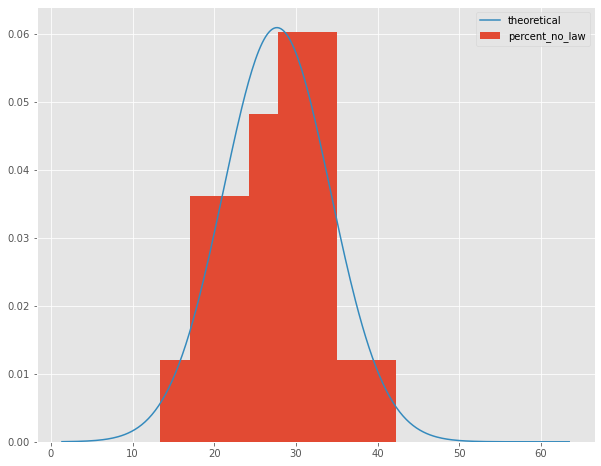

In [23]:
histogram(percent_reject,8)

Построим аналогичное сравнение для штатов, где закон распространяется на гос служащих. Видим отклонения от колоколообразной формы за счет высоких значений, небольшую асимметрию.

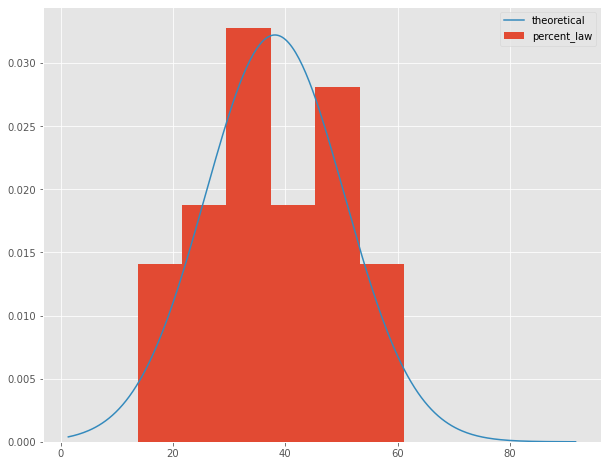

In [24]:
histogram(percent_adopt,6)

Используем критерий для проверки гипотезы о нормальности каждого из двух распределений. В обоих случаях имеем нулевую и альтернативную гипотезы:

<b>Гипотеза H0 </b>: распределение случайной величины "доля муниципальных служащих профсоюзов" с принятым/не принятым законом является нормальным

<b>Гипотеза H1 </b>: распределение случайной величины "доля муниципальных служащих профсоюзов" с принятым/не принятым законом не является нормальным

Для проверки гипотезы воспользуемся критерием Шапиро - Уилка. Уровень значимости = 0.05. Если полученное p-value больше уровня значимости, то нет оснований отвергать нулевую гипотезу. Иначе - будем отвергать нулевую гипотезу.

In [25]:
alpha = 0.05
print('Для штатов, где закон не распространяется:')
shapiro_test(percent_reject, alpha)

print('Для штатов, где закон распространяется:')
shapiro_test(percent_adopt, alpha)

Для штатов, где закон не распространяется:
Не отвергаем H0 о нормальности распределения, p-value = 0.943257212638855
Для штатов, где закон распространяется:
Не отвергаем H0 о нормальности распределения, p-value = 0.7401027679443359


Видим, что гипотеза о нормальности распределения не отвергается (для % служащих в штатах с принятым и не принятым законом). Иными словами - распределения долей служащих нормальны.

### ШАГ 4. Проверка гипотезы о равенстве процентов муниципальных служащих профсоюзов.

Будем проверять гипотезу о равенстве средних (т.е. типичных) значений двух распределений. Для проверки применим критерий Стьюдента, предварительно проверив равенство дисперсий.

Итак, по порядку. Построим на одном графике гистограммы распределений.

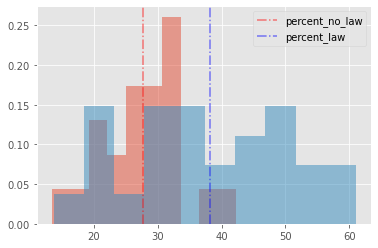

In [26]:
two_hist(percent_reject, percent_adopt)

Критерием Флигнера-Килина проверим, равны ли дисперсии. Позволю себе не дублировать формулировку гипотез. 

In [27]:
alpha = 0.05
fligner_test(percent_reject, percent_adopt, alpha)

Отвергаем H0 о равенстве дисперсий, p-value = 0.0022863939638667475


Значение p-value меньше уровня значимости 0.05, поэтому гипотезу о равенстве дисперсий отвергаем. В двух выборках находятся разные  объекты, значит выборки независимые. 

Поэтому гипотезу о равенстве средних значений будем проверять с помощью (```ttest```) с опцией неравенства дисперсий.

In [28]:
alpha = 0.05
t_test_nonequal(percent_reject, percent_adopt, alpha)

Отвергаем H0 о равенстве средних в предположении различных дисперсий, p-value = 0.0005628173082035911


Таким образом, гипотеза о равенстве средних значений двух выборок отвергается.

<b>Доли муниципальных служащих в штатах, где закон на них распространяется или нет, отличаются (статистически значимое различие с уровнем значимости 0.05) </b>

### ШАГ 5. Построение ящиковой диаграммы, выводы

Построим ящиковую диаграмму. Медианная доля муниципальных служащих больше в штатах, где закон действует на гос. работников, чем в штатах, где закон на них не распространяется. И снова медиана одного класса не попадает в межквартильный размах другого класса.

Например, медианное значение доли служащих, где закон действует = 37.3% > 32.25% = квартиль 75% в штатах с недействующим на гос работников законом.

Также можно видеть, межквартильный размах для штатов с действующим законом больше. 

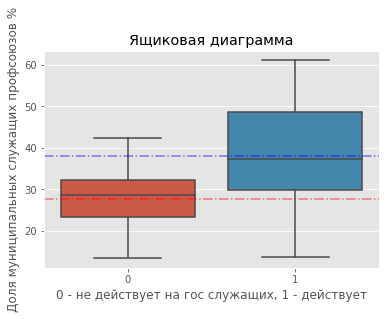

In [30]:
sns.boxplot(data=data, x='COMP', y='DENS')
plt.axhline(percent_reject.mean(), alpha = 0.5, color = 'red', linestyle = '-.')
plt.axhline(percent_adopt.mean(), alpha = 0.5, color = 'blue', linestyle = '-.')
plt.title('Ящиковая диаграмма')
plt.ylabel('Доля муниципальных служащих профсоюзов %')
plt.xlabel('0 - не действует на гос служащих, 1 - действует')
plt.show()

### Вывод по задаче №2:

В данной задаче сравнивались доли муниципальных служащих, а точнее: проверялась гипотеза о равенстве долей служащих в штатах, где закон о ведении переговоров распространяется на гос служащих, и в штатах, где не распространяется. 

% гос служащих отличается в штатах с действующим и недействующим на них законом. Для обоснования данного вывода были построены гистограмммы распределений (с проверкой гипотезы об их нормальности), проверены гипотезы о: равенстве дисперсий, о равенстве  средних значений распределений. Гипотеза о равенстве средних значений была отвергнута. Уровень значимости при проверке гипотез равнялся 0.05.

### Выводы по задачам 1-2:

В работе были проверены статистические гипотезы: для каждой задачи сформулированы основная и альтернативная гипотезы. При проверке гипотез сравнивались центры распределений. 

Обоснование применяемых критериев, построение гистограмм и ящиковых диаграмм приведено в ходе решения.